In [1]:
# 检查是否有可用的 GPU
import torch

print("是否有可用的 CUDA: ", torch.cuda.is_available())

if torch.cuda.is_available():
    # 获取当前设备
    current_device = torch.cuda.current_device()
    print("当前使用的 GPU 设备: ", current_device)

    # 获取 GPU 名称
    device_name = torch.cuda.get_device_name(current_device)
    print("GPU 设备名称: ", device_name)

    # 获取可用的 GPU 数量
    gpu_count = torch.cuda.device_count()
    print("可用的 GPU 数量: ", gpu_count)

    # 获取当前 GPU 的显存使用情况
    print("\n显存使用情况:")
    print("分配的显存: ", torch.cuda.memory_allocated(current_device) / 1024**2, "MB")
    print("缓存的显存: ", torch.cuda.memory_reserved(current_device) / 1024**2, "MB")
else:
    print("警告: 没有检测到可用的 GPU 设备!")


是否有可用的 CUDA:  True
当前使用的 GPU 设备:  0
GPU 设备名称:  NVIDIA RTX A6000
可用的 GPU 数量:  4

显存使用情况:
分配的显存:  0.0 MB
缓存的显存:  0.0 MB


# 预处理获取眼部区域

In [1]:
import os
import cv2 as cv
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, HBox, VBox, Output, Dropdown
from IPython.display import display

class Undistorter:
    _map = None
    _previous_parameters = None

    def __call__(self, image, camera_matrix, distortion, is_gazecapture=False):
        h, w, _ = image.shape
        all_parameters = np.concatenate([camera_matrix.flatten(),
                                         distortion.flatten(),
                                         [h, w]])
        if (self._previous_parameters is None
                or len(self._previous_parameters) != len(all_parameters)
                or not np.allclose(all_parameters, self._previous_parameters)):
            self._map = cv.initUndistortRectifyMap(
                camera_matrix, distortion, R=None,
                newCameraMatrix=camera_matrix if is_gazecapture else None,
                size=(w, h), m1type=cv.CV_32FC1)
            self._previous_parameters = np.copy(all_parameters)
        return cv.remap(image, self._map[0], self._map[1], cv.INTER_LINEAR)

# Initialize Undistorter
undistort = Undistorter()

def draw_gaze(image_in, eye_pos, pitchyaw, length=40.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze direction"""
    image_out = image_in.copy()
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv.cvtColor(image_out, cv.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1])
    dy = -length * np.sin(pitchyaw[0])
    cv.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx,
                                   eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv.LINE_AA, tipLength=0.2)
    return image_out

def vector_to_pitchyaw(vectors):
    """Convert gaze vectors to pitch and yaw angles"""
    n = vectors.shape[0]
    out = np.empty((n, 2))
    vectors = np.divide(vectors, np.linalg.norm(vectors, axis=1).reshape(n, 1))
    out[:, 0] = np.arcsin(vectors[:, 1])  # theta
    out[:, 1] = np.arctan2(vectors[:, 0], vectors[:, 2])  # phi
    return out

# Load face model and other required data
face_model_fpath = '/home/xuhy/PycharmProjects/STED-gaze/preprocess/faze_preprocess/sfm_face_coordinates.npy'
face_model_3d_coordinates = np.load(face_model_fpath)

# Supplementary data paths
supplementary_path = '/home/xuhy/PycharmProjects/STED-gaze/preprocess/faze_preprocess/GazeCapture_supplementary.h5'
dataset_path = '/mnt/data/xhy/gazecapture'  # Original dataset path

# Create interactive processing function
def process_sample(focal_length=800, distance=800, width=256, height=64, sample_idx=0):
    # Set normalized camera parameters
    normalized_camera = {
        'focal_length': focal_length,
        'distance': distance,
        'size': (width, height),
    }

    norm_camera_matrix = np.array([
        [normalized_camera['focal_length'], 0, 0.5*normalized_camera['size'][0]],
        [0, normalized_camera['focal_length'], 0.5*normalized_camera['size'][1]],
        [0, 0, 1],
    ], dtype=np.float64)

    # Cache some examples here to avoid reloading every time
    if not hasattr(process_sample, 'samples_cache'):
        process_sample.samples_cache = []
        with h5py.File(supplementary_path, 'r') as f:
            for i, person_id in enumerate(list(f.keys())[:10]):
                if i >= 5:  # Only cache a few samples
                    break
                group = f[person_id]
                num_entries = next(iter(group.values())).shape[0]
                for j in range(min(3, num_entries)):
                    # Basic information
                    fx, fy, cx, cy = group['camera_parameters'][j, :]
                    camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)
                    distortion = group['distortion_parameters'][j, :]
                    image_path = '%s/%s' % (dataset_path, group['file_name'][j].decode('utf-8'))

                    try:
                        # Load image
                        image = cv.imread(image_path, cv.IMREAD_COLOR)
                        if image is None:
                            continue

                        # Undistort
                        image = undistort(image, camera_matrix, distortion, is_gazecapture=True)
                        image = image[:, :, ::-1]  # BGR to RGB

                        # Head pose
                        rvec = group['head_pose'][j, :3].reshape(3, 1)
                        tvec = group['head_pose'][j, 3:].reshape(3, 1)
                        rotate_mat, _ = cv.Rodrigues(rvec)

                        # Get transformed 3D coordinates
                        landmarks_3d = np.matmul(rotate_mat, face_model_3d_coordinates.T).T
                        landmarks_3d += tvec.T

                        # Gaze information - UPDATED: Using between eyes point
                        g_o = np.mean(landmarks_3d[10:12, :], axis=0).reshape(3, 1)  # between 2 eyes
                        # g_o = landmarks_3d[-1, :].reshape(3, 1)
                        g_t = group['3d_gaze_target'][j, :].reshape(3, 1)
                        g = g_t - g_o
                        g /= np.linalg.norm(g)

                        # Cache sample data
                        process_sample.samples_cache.append({
                            'person_id': person_id,
                            'sample_idx': j,
                            'image': image,
                            'camera_matrix': camera_matrix,
                            'rotate_mat': rotate_mat,
                            'g_o': g_o,
                            'g': g,
                            'landmarks_3d': landmarks_3d,
                            'tvec': tvec,
                        })
                    except Exception as e:
                        print(f"Error processing sample {person_id}/{j}: {e}")

    # Check if there are available cached samples
    if not process_sample.samples_cache:
        return plt.figure(), "Unable to load sample data"

    # Get cached sample
    sample_idx = min(sample_idx, len(process_sample.samples_cache) - 1)
    sample = process_sample.samples_cache[sample_idx]

    # Apply new parameters to process image
    image = sample['image']
    camera_matrix = sample['camera_matrix']
    rotate_mat = sample['rotate_mat']
    g_o = sample['g_o']
    g = sample['g']
    landmarks_3d = sample['landmarks_3d']

    # Calculate actual distance and scaling
    distance_actual = np.linalg.norm(g_o)
    z_scale = distance / distance_actual
    S = np.eye(3, dtype=np.float64)
    S[2, 2] = z_scale

    # Calculate rotation matrix
    hRx = rotate_mat[:, 0]
    forward = (g_o / distance_actual).reshape(3)
    down = np.cross(forward, hRx)
    down /= np.linalg.norm(down)
    right = np.cross(down, forward)
    right /= np.linalg.norm(right)
    R = np.c_[right, down, forward].T

    # Transformation matrix
    W = np.dot(np.dot(norm_camera_matrix, S),
               np.dot(R, np.linalg.inv(camera_matrix)))

    # Image normalization
    ow, oh = normalized_camera['size']
    patch = cv.warpPerspective(image, W, (ow, oh))

    # Process gaze direction
    R = np.asmatrix(R)
    n_g = R * g
    n_g /= np.linalg.norm(n_g)
    n_g = vector_to_pitchyaw(-n_g.T).flatten()

    # Visualization
    to_visualize = cv.equalizeHist(cv.cvtColor(patch, cv.COLOR_RGB2GRAY))

    # Adjust eye position based on image dimensions
    eye_x = 0.5 * ow  # Center horizontally
    eye_y = 0.3 * oh  # 30% from top

    to_visualize = draw_gaze(to_visualize, (eye_x, eye_y), n_g,
                           length=min(80.0, ow*0.3), thickness=1)

    # # Display results
    # fig, ax = plt.subplots(figsize=(10, 4))
    # ax.imshow(to_visualize, cmap='gray')
    # ax.set_title(f"ID: {sample['person_id']}, FL: {focal_length}, Dist: {distance}, Size: {width}x{height}")
    # ax.axis('off')
    # plt.tight_layout()
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    # 显示原图（已undistort和BGR转RGB）
    axes[0].imshow(sample['image'])
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    # 显示归一化图像
    axes[1].imshow(to_visualize, cmap='gray')
    axes[1].set_title(f"Normalized\nID: {sample['person_id']}, FL: {focal_length}, Dist: {distance}, Size: {width}x{height}")
    axes[1].axis('off')
    plt.tight_layout()

    return fig, f"Processing successful: FL={focal_length}, Dist={distance}, Size={width}x{height}"

# Predefined resolution options
resolution_presets = {
    '256x64 (Default)': (256, 64),
    '128x128 (Square)': (128, 128),
    '224x224 (VGG)': (224, 224),
    '160x160 (FaceNet)': (160, 160),
    '96x96 (Small)': (96, 96),
    '384x96 (Wide)': (384, 96),
    '256x32 (Eyes Only)': (256, 32),  # Added a new preset for eyes only
    'Custom': (-1, -1),  # Placeholder for custom resolution
}

# Create interactive interface
output = Output()

# Custom resolution widgets
width_slider = IntSlider(min=64, max=1024, step=16, value=256, description='Width:')
height_slider = IntSlider(min=32, max=1024, step=16, value=64, description='Height:')

# Resolution preset dropdown
resolution_dropdown = Dropdown(
    options=list(resolution_presets.keys()),
    value='256x64 (Default)',
    description='Resolution:',
)

# Function to update custom resolution sliders based on dropdown selection
def update_resolution_sliders(change):
    if change['new'] != 'Custom':
        width, height = resolution_presets[change['new']]
        width_slider.value = width
        height_slider.value = height

resolution_dropdown.observe(update_resolution_sliders, names='value')

@interact
def interactive_normalize(
    focal_length=IntSlider(min=300, max=2000, step=100, value=800, description='Focal Length:'),
    distance=IntSlider(min=300, max=2000, step=100, value=600, description='Distance:'),
    resolution=resolution_dropdown,
    custom_width=width_slider,
    custom_height=height_slider,
    sample_idx=IntSlider(min=0, max=9, step=1, value=0, description='Sample:')
):
    output.clear_output()
    with output:
        # Determine which width and height to use
        if resolution == 'Custom':
            width = custom_width
            height = custom_height
        else:
            width, height = resolution_presets[resolution]

        fig, status = process_sample(focal_length, distance, width, height, sample_idx)
        print(status)
        plt.show()

# Display output
display(output)


interactive(children=(IntSlider(value=800, description='Focal Length:', max=2000, min=300, step=100), IntSlide…

Output()

# 人脸身份识别

{'verified': True, 'distance': 0.6156723820753621, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 127, 'h': 127, 'left_eye': None, 'right_eye': None}, 'img2': {'x': 0, 'y': 0, 'w': 127, 'h': 127, 'left_eye': None, 'right_eye': None}}, 'time': 1.15}


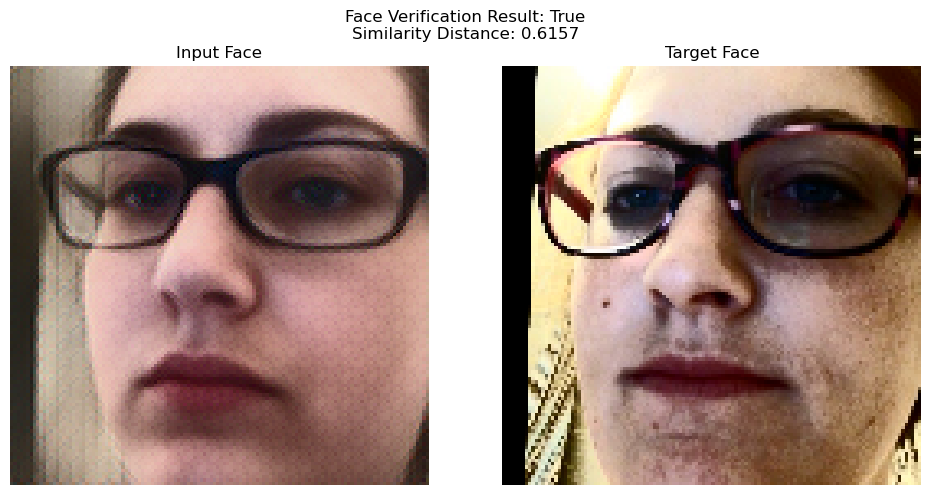

In [8]:
from deepface import DeepFace
result = DeepFace.verify(img1_path = "/home/xuhy/PycharmProjects/STED-gaze/logs/5-21/samples/190/redirect_206864.png",
                         img2_path = "/home/xuhy/PycharmProjects/STED-gaze/logs/5-21/samples/190/target_image.png")
print(result)

# 显示输入人脸和目标人脸的对比结果
import cv2
import matplotlib.pyplot as plt

# 读取两张图片
img1 = cv2.imread("/home/xuhy/PycharmProjects/STED-gaze/logs/5-21/samples/190/redirect_206864.png")
img2 = cv2.imread("/home/xuhy/PycharmProjects/STED-gaze/logs/5-21/samples/190/target_image.png")

# BGR转RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# 创建图像显示
plt.figure(figsize=(10,5))

# 显示输入人脸
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Input Face')
plt.axis('off')

# 显示目标人脸
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Target Face')
plt.axis('off')

# 添加验证结果信息
plt.suptitle(f'Face Verification Result: {result["verified"]}\nSimilarity Distance: {result["distance"]:.4f}')

plt.tight_layout()
plt.show()



# DataLoader检查

In [2]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
import numpy as np
from collections import OrderedDict
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Subset
import logging
from dataset import HDFDataset
from utils import save_images, worker_init_fn, send_data_dict_to_gpu, recover_images, def_test_list, RunningStatistics,\
    adjust_learning_rate, script_init_common, get_example_images, save_model, load_model
from core import DefaultConfig
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings('ignore')
# Create the train and test datasets.
all_data = OrderedDict()
# Read GazeCapture train/val/test split
with open('./gazecapture_split.json', 'r') as f:
    all_gc_prefixes = json.load(f)
    # Define single training dataset
    train_prefixes = all_gc_prefixes['train']
    train_dataset = HDFDataset(hdf_file_path="/mnt/data/xhy/outputs_sted/GazeCapture.h5",
                               prefixes=train_prefixes,
                               is_bgr=False,
                               get_2nd_sample=True,
                               num_labeled_samples=None)
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=32,
                                  shuffle=True,
                                  drop_last=True,
                                  num_workers=4,
                                  pin_memory=True,
                                  )
    # print(train_dataloader)
    all_data['gc/train'] = {'dataset': train_dataset, 'dataloader': train_dataloader}
    train_data_iterator = iter(train_dataloader)
    input = next(train_data_iterator)
    print(input["key"])
    print(input["image_a"].shape)
    # print(input["image_b"].shape)
    print(input["head_a"].shape)
    print(input["gaze_a"].shape)
    # print(input["head_b"].shape)
    # print(input["gaze_b"].shape)
    print(input["image_a"][0].shape)
    print(input["gaze_a"][0].shape)
    print(input["head_a"][0].shape)
    print(input["mask_a"][0].shape)
    print(input["mask_a"].shape)
    print(input["boundary_mask_a"].shape)


['01262', '00239', '03137', '01965', '02879', '01015', '01653', '03277', '00934', '00668', '01706', '03378', '01209', '01806', '00212', '03336', '00525', '02705', '01191', '01388', '01897', '00210', '00945', '02361', '02540', '01362', '02868', '00676', '01606', '02525', '02114', '01979']
torch.Size([32, 3, 128, 128])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([3, 128, 128])
torch.Size([2])
torch.Size([2])
torch.Size([128, 128])
torch.Size([32, 128, 128])
torch.Size([32, 128, 128])


# Decoder test


In [1]:
from core import DefaultConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.densenet import DenseNetBlock, DenseNetTransitionUp, DenseNetDecoderLastLayers
config = DefaultConfig()
class Decoder(nn.Module):
    def __init__(self, num_all_embedding_features, target_shape=(256, 64)):
        super().__init__()
        self.target_shape = target_shape
        # DenseNetDecoder 只上采样到 32x8
        self.bottleneck_shape = (2, 8)
        self.num_blocks = 4
        decoder_input_c = int(num_all_embedding_features / np.prod(self.bottleneck_shape))
        self.decoder_input_c = decoder_input_c
        self.decoder = DenseNetDecoder(
            self.decoder_input_c,
            num_blocks=self.num_blocks,
            compression_factor=0.5,  # 降低通道数
        )
        self.use_fc = num_all_embedding_features != decoder_input_c * np.prod(self.bottleneck_shape)
        if self.use_fc:
            self.fc_dec = nn.Linear(num_all_embedding_features, decoder_input_c * np.prod(self.bottleneck_shape))
        # 轻量上采样到 256x64
        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x8 -> 64x16
            nn.Conv2d(self.decoder.last.c_now, 64, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64x16 -> 128x32
            nn.Conv2d(64, 32, 3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 128x32 -> 256x64
            nn.Conv2d(32, 16, 3, padding=1),
            nn.InstanceNorm2d(16),
            nn.LeakyReLU(inplace=True),
        )
        self.final_conv = nn.Conv2d(16, 3, 3, padding=1)
        self.final_act = nn.Tanh()

    def forward(self, embeddings, target_shape=None):
        x = torch.cat([e.reshape(e.shape[0], -1) for e in embeddings], dim=-1)
        if self.use_fc:
            x = self.fc_dec(x)
        x = x.view(-1, self.decoder_input_c, *self.bottleneck_shape)
        x = self.decoder(x)
        x = self.upsample_blocks(x)
        x = self.final_conv(x)
        x = self.final_act(x)
        return x


class DenseNetDecoder(nn.Module):

    def __init__(self, c_in, num_blocks=4, num_layers_per_block=4,
                 p_dropout=0.0, compression_factor=1.0,
                 activation_fn=nn.LeakyReLU, normalization_fn=nn.InstanceNorm2d):
        super(DenseNetDecoder, self).__init__()


        c_to_concat = [0] * (num_blocks + 2)

        assert (num_layers_per_block % 2) == 0
        c_now = c_in
        for i in range(num_blocks):
            i_ = i + 1
            # Define dense block
            self.add_module('block%d' % i_, DenseNetBlock(
                c_now,
                num_layers=num_layers_per_block,
                growth_rate=config.growth_rate,
                p_dropout=p_dropout,
                activation_fn=activation_fn,
                normalization_fn=normalization_fn,
                transposed=True,
            ))
            c_now = list(self.children())[-1].c_now

            # Define transition block if not last layer
            if i < (num_blocks - 1):
                self.add_module('trans%d' % i_, DenseNetTransitionUp(
                    c_now, p_dropout=p_dropout,
                    compression_factor=compression_factor,
                    activation_fn=activation_fn,
                    normalization_fn=normalization_fn,
                ))
                c_now = list(self.children())[-1].c_now
                c_now += c_to_concat[i]

        # Last up-sampling conv layers
        self.last = DenseNetDecoderLastLayers(c_now,
                                              growth_rate=config.growth_rate,
                                              activation_fn=activation_fn,
                                              normalization_fn=normalization_fn,
                                              )
        self.c_now = 1

    def forward(self, x):
        # Apply initial layers and dense blocks
        for name, module in self.named_children():
            x = module(x)
        return x


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from dataset import HDFDataset

# 替换为你的HDF5文件路径
hdf_path = '/mnt/data/xhy/outputs_sted256_64/GazeCapture.h5'

# 初始化数据集
dataset = HDFDataset(hdf_path)

# 读取一条数据
sample = dataset[1]  # 你可以用其他索引

# 还原原图像（[C,H,W] -> [H,W,C], [-1,1] -> [0,255]）
img = sample['image_a']
img = img.cpu().numpy() if hasattr(img, 'cpu') else img  # 转为numpy
img = np.transpose(img, (1, 2, 0))  # [H, W, C]
img = ((img + 1) * 127.5).astype(np.uint8)

# 读取mask
if np.sum(sample['mask_a']) > 0:
    mask = sample['mask_a']  # [H, W], float32
else:
    print("mask is None")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Eye Mask')
axes[1].axis('off')

# 叠加显示
overlay = img.copy()
overlay[mask > 0.2] = [255, 0, 0]  # mask区域用红色高亮
axes[2].imshow(overlay)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


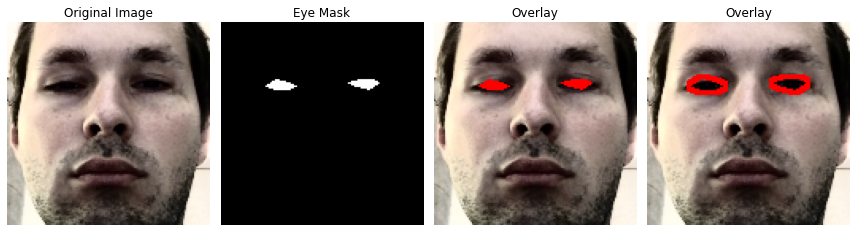

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from dataset import HDFDataset

# 替换为你的HDF5文件路径
hdf_path = '/mnt/data/xhy/outputs_sted/GazeCapture.h5'

# 初始化数据集
dataset = HDFDataset(hdf_path)

# 读取一条数据
sample = dataset[300]  # 你可以用其他索引

# 还原原图像（[C,H,W] -> [H,W,C], [-1,1] -> [0,255]）
img = sample['image_a']
img = img.cpu().numpy() if hasattr(img, 'cpu') else img  # 转为numpy
img = np.transpose(img, (1, 2, 0))  # [H, W, C]
img = ((img + 1) * 127.5).astype(np.uint8)
mask = sample['mask_a']
boundary_mask = sample['boundary_mask_a']
if hasattr(mask, 'cpu'):
    mask = mask.cpu().numpy()
if hasattr(boundary_mask, 'cpu'):
    boundary_mask = boundary_mask.cpu().numpy()
# 读取mask
if np.sum(mask) > 0:
    mask = mask  # [H, W], float32
else:
    print("mask is None")

# 可视化
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Eye Mask')
axes[1].axis('off')

# 叠加显示
overlay = img.copy()
overlay[mask > 0.2] = [255, 0, 0]  # mask区域用红色高亮
axes[2].imshow(overlay)
axes[2].set_title('Overlay')
axes[2].axis('off')

overlay = img.copy()
overlay[boundary_mask > 0.2] = [255, 0, 0]  # mask区域用红色高亮
axes[3].imshow(overlay)
axes[3].set_title('Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()


In [2]:
import torch
from models import STED
from core import DefaultConfig
from utils import send_data_dict_to_gpu

# 配置
config = DefaultConfig()
# config.num_2d_units = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设输入分辨率为 (3, 256, 256)，batch_size=2
batch_size = 2
img_shape = (3, 128, 128)

# 构造假数据
angle_range = (-0.5 * torch.pi, 0.5 * torch.pi)
dummy_data = {
    'image_a': torch.randn(batch_size, *img_shape, device=device),
    'gaze_a': (torch.rand(batch_size, 2, device=device) - 0.5) * torch.pi,  # [-pi/2, pi/2]
    'head_a': (torch.rand(batch_size, 2, device=device) - 0.5) * torch.pi,
    'image_b': torch.randn(batch_size, *img_shape, device=device),
    'gaze_b': (torch.rand(batch_size, 2, device=device) - 0.5) * torch.pi,
    'head_b': (torch.rand(batch_size, 2, device=device) - 0.5) * torch.pi,
    'mask_a': torch.ones(batch_size, 1, 128, 128, device=device),
    'mask_b': torch.ones(batch_size, 1, 128, 128, device=device),
    'boundary_mask_a': torch.zeros(batch_size, 1, 128, 128, device=device),
}
print(dummy_data['gaze_a'])

# # 如果 mask 需要 shape [B, 1, H, W]，可加 unsqueeze(1)
for k in ['mask_a', 'mask_b', 'boundary_mask_a']:
    if dummy_data[k].dim() == 3:
        dummy_data[k] = dummy_data[k].unsqueeze(1)

# 实例化模型
model = STED().to(device)
model.eval()

# 前向传播
with torch.no_grad():
    output_dict, loss_dict = model(dummy_data)
    print("Forward success!")
    print("Output keys:", list(output_dict.keys()))
    print("Loss keys:", list(loss_dict.keys()))


tensor([[-1.2735, -1.1445],
        [-0.5916, -1.0347]], device='cuda:0')
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/xuhy/anaconda3/envs/sted/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Forward success!
Output keys: ['image_b_hat', 'blend']
Loss keys: ['gaze_a', 'head_a', 'head_to_gaze', 'gaze_to_head', 'gaze_disentangle', 'head_disentangle', 'head_redirection', 'gaze_redirection', 'lpips', 'l1_eye', 'l1_boundary', 'lpips_eye', 'lpips_boundary']
